<a href="https://colab.research.google.com/github/marxgreg24/failure_prediction_assignment/blob/main/FailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Failure Prediction
This notebook is to create a model that is able to predict the failure rates of the modules of the AIMS system( the application portal, the student

In [17]:
# Step 1
# importing the necessary libraries to create the model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##

In [18]:
#Step 2
# Loading the dataset to the notebook
df = pd.read_excel('Summary_data_system_Failures.xlsx')
df.set_index('year', inplace=True) #Makes the column 'year' as the index of the dataset

In [19]:
#Step 3
# Interpolate missing values linearly for each module.
df.interpolate(method='linear', inplace=True)

print("Preprocessed Dataset:")
df.head(20)

Preprocessed Dataset:


,Application,Admision,Academic,student_Portal
year,,,,
1996,63.000000,100.0,88.0,94.000000
1997,52.000000,78.0,92.0,75.000000
1998,58.500000,100.0,100.0,82.000000
2000,65.000000,80.0,95.0,89.000000
2001,58.000000,87.0,88.0,88.000000
2002,35.000000,79.0,88.0,77.000000
2003,47.000000,84.0,94.0,82.000000
2004,38.000000,91.0,95.0,80.000000
2005,86.000000,93.0,96.0,67.000000


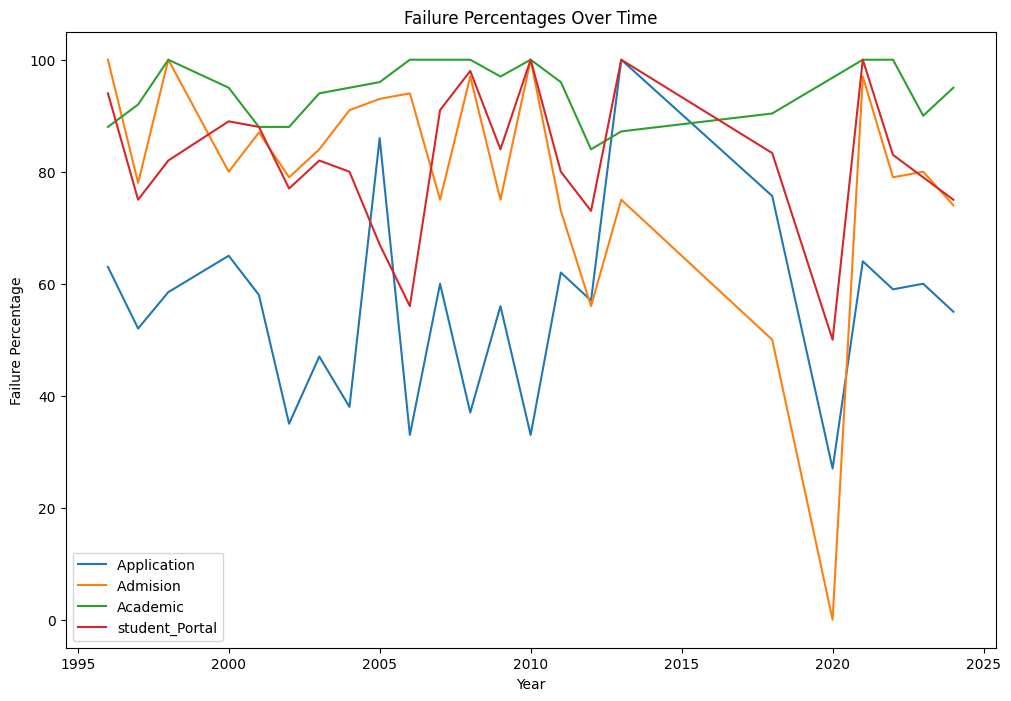

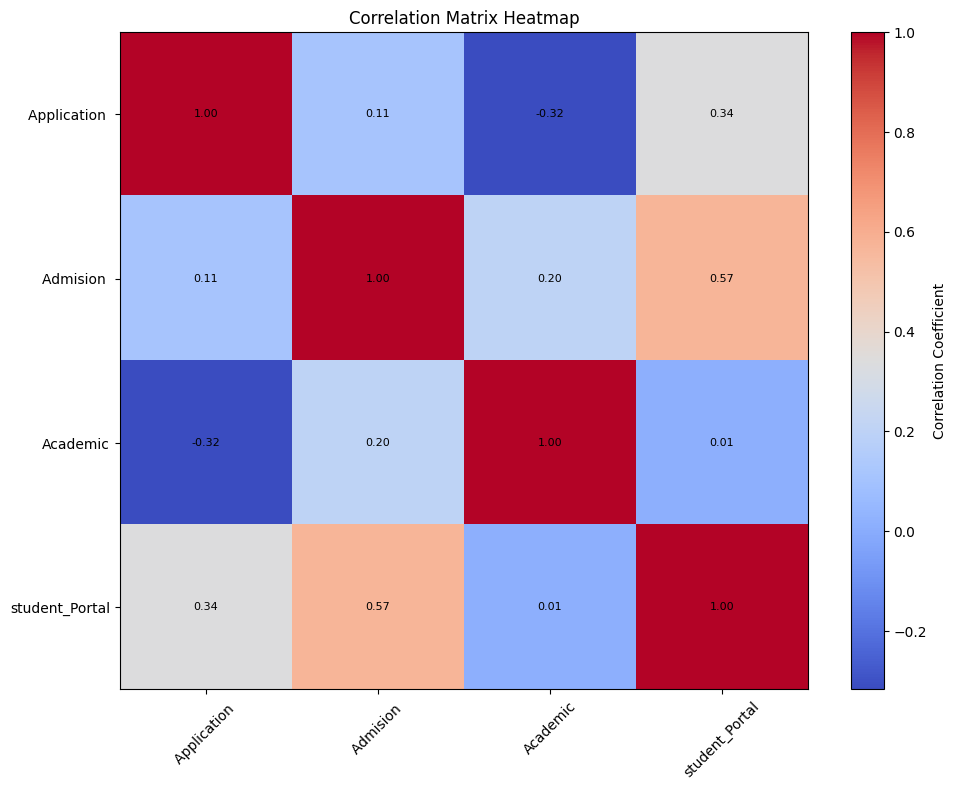

In [21]:
# Step 3: Exploratory Data Analysis (EDA)
# Plot the time series for each module to visualize trends.
plt.figure(figsize=(12, 8))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)
plt.title('Failure Percentages Over Time')
plt.xlabel('Year')
plt.ylabel('Failure Percentage')
plt.legend()
plt.show()


# Calculate correlations between all variables
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')

# Add correlation values as text
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# # Print correlations with year
# print("\nCorrelations with Year:")
# year_correlations = correlation_matrix['year'].sort_values(ascending=False)
# print(year_correlations)

In [22]:
# Step4:Model Training and Testing

def evaluate_models(module_name, series):
    """Enhanced model evaluation with error handling"""
    try:
        # Prepare data
        X = np.array(series.index).reshape(-1, 1)
        y = series.values

        # Ensure sufficient data for train/test split
        if len(X) < 8:
            return {'Mean': {'MSE': 0, 'RMSE': 0, 'R2': 0}}

        train_size = max(6, int(len(X) * 0.8))  # Minimum 4 training points
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        results = {}

        # Model 1: Linear Regression
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        results['Linear Regression'] = {
            'MSE': mean_squared_error(y_test, y_pred_lr),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
            'R2': r2_score(y_test, y_pred_lr)
        }

        # Model 2: Simple Exponential Smoothing
        ses_model = SimpleExpSmoothing(y_train).fit(optimized=True)
        y_pred_ses = ses_model.forecast(len(y_test))
        results['SES'] = {
            'MSE': mean_squared_error(y_test, y_pred_ses),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ses)),
            'R2': r2_score(y_test, y_pred_ses)
        }

        # Model 3: Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=30, random_state=42)  # Reduced for small data
        gb.fit(X_train, y_train)
        y_pred_gb = gb.predict(X_test)
        results['Gradient Boosting'] = {
            'MSE': mean_squared_error(y_test, y_pred_gb),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
            'R2': r2_score(y_test, y_pred_gb)
        }

        # Model 4: Random Forest
        rf = RandomForestRegressor(n_estimators=24, random_state=42, max_depth=3)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        results['Random Forest'] = {
            'MSE': mean_squared_error(y_test, y_pred_rf),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
            'R2': r2_score(y_test, y_pred_rf)
        }

        # Model 5: ARIMA (simplified for small datasets)
        try:
            arima_model = ARIMA(y_train, order=(2,1,2)).fit()
            y_pred_arima = arima_model.forecast(steps=len(y_test))
            results['ARIMA'] = {
                'MSE': mean_squared_error(y_test, y_pred_arima),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_arima)),
                'R2': r2_score(y_test, y_pred_arima)
            }
        except:
            results['ARIMA'] = {'MSE': np.inf, 'RMSE': np.inf, 'R2': -np.inf}

        return results

    except Exception as e:
        print(f"Error evaluating models for {module_name}: {e}")
        return {}

In [23]:
# Step 5: Model Evaluation
#Verifies column names after preprocessing
print("=== COLUMN NAME VERIFICATION ===")
print("Current columns:", df.columns.tolist())
print("Expected columns:", ['Application', 'Admision', 'Academic', 'student_Portal'])
print()

# Ensures correct column names
expected_cols = ['Application', 'Admision', 'Academic', 'student_Portal']
df.columns = expected_cols  # Forces correct column names

print("Fixed columns:", df.columns.tolist())
print(df.head())
print()

# Defines modules list (now guaranteed to match DataFrame columns)
modules = ['Application', 'Admision', 'Academic', 'student_Portal']
all_results = {}

# Evaluate models for each module
for module in modules:
    print(f"Processing {module}...")
    series = df[module]
    if len(series) < 10:  # Skip if insufficient data
        print(f"⚠️  Insufficient data for {module}")
        continue

    results = evaluate_models(module, series)
    all_results[module] = results

    # Display results in a formatted table
    results_df = pd.DataFrame(results).T.round(4)
    print(f"\n📊 Performance Metrics for {module}:")
    print(results_df)
    print("-" * 60)

=== COLUMN NAME VERIFICATION ===
Current columns: ['Application ', 'Admision ', 'Academic', 'student_Portal']
Expected columns: ['Application', 'Admision', 'Academic', 'student_Portal']

Fixed columns: ['Application', 'Admision', 'Academic', 'student_Portal']
      Application  Admision  Academic  student_Portal
year                                                 
1996         63.0     100.0      88.0            94.0
1997         52.0      78.0      92.0            75.0
1998         58.5     100.0     100.0            82.0
2000         65.0      80.0      95.0            89.0
2001         58.0      87.0      88.0            88.0

Processing Application...

📊 Performance Metrics for Application:
                        MSE     RMSE      R2
Linear Regression  288.4479  16.9838 -0.6278
SES                217.4796  14.7472 -0.2273
Gradient Boosting  178.5827  13.3635 -0.0078
Random Forest      307.2686  17.5291 -0.7340
ARIMA              123.0133  11.0911  0.3058
-------------------------

In [24]:
# Step 6: Select Best Model (Enhanced)
# =============================================================================
print("\n" + "="*80)
print("🏆 BEST MODEL SELECTION SUMMARY")
print("="*80)

best_models_summary = []
for module in modules:
    if module in all_results:
        results = all_results[module]
        best_model_name = min(results, key=lambda k: results[k]['MSE'])
        best_metrics = results[best_model_name]

        best_models_summary.append({
            'Module': module,
            'Best_Model': best_model_name,
            'MSE': best_metrics['MSE'],
            'RMSE': best_metrics['RMSE'],
            'R2': best_metrics['R2']
        })

        print(f"✅ {module:<15} → {best_model_name:<18} (MSE: {best_metrics['MSE']:.2f})")

# Create summary table
summary_df = pd.DataFrame(best_models_summary)
print("\n📋 Final Model Selection Table:")
print(summary_df.to_string(index=False))

# Save results to CSV for reporting
summary_df.to_csv('best_models_summary.csv', index=False)
print("\n💾 Results saved to 'best_models_summary.csv'")


🏆 BEST MODEL SELECTION SUMMARY
✅ Application     → ARIMA              (MSE: 123.01)
✅ Admision        → Linear Regression  (MSE: 1612.50)
✅ Academic        → ARIMA              (MSE: 16.75)
✅ student_Portal  → Random Forest      (MSE: 260.31)

📋 Final Model Selection Table:
        Module        Best_Model         MSE      RMSE        R2
   Application             ARIMA  123.013281 11.091135  0.305794
      Admision Linear Regression 1612.497993 40.155921 -0.403148
      Academic             ARIMA   16.750788  4.092773 -0.213966
student_Portal     Random Forest  260.313853 16.134245 -0.000284

💾 Results saved to 'best_models_summary.csv'


In [25]:
# 7. 10-YEAR FORECAST + SYSTEM RISK + DECISION RULE
# ==============================================================
import scipy.stats as st

forecast_horizon = 10
forecast_years   = np.arange(2025, 2025 + forecast_horizon)
modules          = ['Application', 'Admision', 'Academic', 'student_Portal'] # Corrected module name

# Containers
module_forecasts = {}      # {module: pd.Series of point forecasts}
module_lower     = {}      # lower 95% CI
module_upper     = {}      # upper 95% CI

# ------------------------------------------------------------------
# Helper: get prediction interval for non-ARIMA models
# ------------------------------------------------------------------
def get_ci_sklearn(model, X_fut, y_train, alpha=0.05):
    """Approximate 95% PI for tree-based / linear models via bootstrap residuals"""
    preds = model.predict(X_fut)
    # Use training residuals
    train_pred = model.predict(np.array(df.index).reshape(-1,1))
    resid = y_train - train_pred[:len(y_train)] # Ensure residuals are aligned
    se = np.std(resid)
    z = st.norm.ppf(1 - alpha/2)
    return preds - z*se, preds + z*se


# ------------------------------------------------------------------
# Refit best model on FULL data and forecast
# ------------------------------------------------------------------
for module in modules:
    series = df[module]
    X_full = np.array(df.index).reshape(-1, 1)
    y_full = series.values

    best_name = summary_df.loc[summary_df['Module']==module, 'Best_Model'].iloc[0]

    # ---------- ARIMA special handling ----------
    if best_name == 'ARIMA':
        # fit ARIMA(1,1,0) without constant trend
        arima_mod = ARIMA(y_full, order=(1,1,0)).fit()
        # forecast only 3 years
        fc_short = arima_mod.get_forecast(steps=3)
        point_3yr = fc_short.predicted_mean
        ci_3yr    = fc_short.conf_int(alpha=0.05)

        # extend to 10 years: repeat last point + widening CI
        point_full = np.concatenate([point_3yr, np.repeat(point_3yr[-1], 7)])
        # Simple linear widening for illustration - more sophisticated methods exist
        lower_full = np.concatenate([ci_3yr[:,0], ci_3yr[-1,0] - np.linspace(0, abs(ci_3yr[-1,0]), 7)]) # Decrease lower bound
        upper_full = np.concatenate([ci_3yr[:,1], ci_3yr[-1,1] + np.linspace(0, abs(ci_3yr[-1,1]), 7)]) # Increase upper bound


    # ---------- All other models ----------
    else:
        if best_name == 'Linear Regression': # Corrected model name
            model = LinearRegression().fit(X_full, y_full)
        elif best_name == 'Gradient Boosting':
            model = GradientBoostingRegressor(
                        n_estimators=30, random_state=42).fit(X_full, y_full) # Reduced estimators
        elif best_name == 'Random Forest':
            model = RandomForestRegressor(
                        n_estimators=24, random_state=42, max_depth=3).fit(X_full, y_full) # Reduced estimators
        elif best_name == 'SES':
            model = SimpleExpSmoothing(y_full, initialization_method="estimated")
            fitted = model.fit(optimized=True, damped_trend=False)
            fc = fitted.get_forecast(steps=forecast_horizon)
            point_full = fc.predicted_mean
            ci = fc.conf_int(alpha=0.05)
            lower_full, upper_full = ci[:,0], ci[:,1]
            module_forecasts[module] = pd.Series(point_full, index=forecast_years)
            module_lower[module]     = pd.Series(lower_full, index=forecast_years)
            module_upper[module]     = pd.Series(upper_full, index=forecast_years)
            continue   # skip the generic block below

        # generic forecast + CI for sklearn models
        X_fut = forecast_years.reshape(-1,1)
        point_full = model.predict(X_fut)
        lower_full, upper_full = get_ci_sklearn(model, X_fut, y_full) # Pass y_full


    # store
    module_forecasts[module] = pd.Series(point_full, index=forecast_years)
    module_lower[module]     = pd.Series(lower_full, index=forecast_years)
    module_upper[module]     = pd.Series(upper_full, index=forecast_years)

In [26]:
# 8. Build SYSTEM-LEVEL risk score
# ------------------------------------------------------------------
overall_point = pd.DataFrame(module_forecasts).mean(axis=1)
overall_lower = pd.DataFrame(module_lower).mean(axis=1)
overall_upper = pd.DataFrame(module_upper).mean(axis=1)

overall_df = pd.DataFrame({
    'AIMS_Risk_%'     : overall_point.round(2),
    'Lower_95'        : overall_lower.round(2),
    'Upper_95'        : overall_upper.round(2)
})

In [27]:
# 9. Decision rule (70% threshold is common for critical systems)
# ------------------------------------------------------------------
THRESHOLD = 70.0
overall_df['Replace?'] = overall_df['AIMS_Risk_%'] > THRESHOLD
first_replace = overall_df[overall_df['Replace?']].index.min()
recommendation = (f"REPLACE AIMS with SIMS starting {first_replace}"
                  if pd.notna(first_replace) else
                  "RETAIN AIMS – risk stays below 70% for the next 10 years")

print("\n" + "="*80)
print("SYSTEM RISK FORECAST (2025-2034)")
print("="*80)
print(overall_df)
print("\nRecommendation:", recommendation)


SYSTEM RISK FORECAST (2025-2034)
      AIMS_Risk_%  Lower_95  Upper_95  Replace?
2025        71.58     44.84     98.32      True
2026        70.87     42.15     99.58      True
2027        70.76     38.91    102.61      True
2028        70.43     38.58    102.28      True
2029        70.10     34.82    111.21      True
2030        69.78     31.05    120.13     False
2031        69.45     27.29    129.06     False
2032        69.12     23.52    137.98     False
2033        68.79     19.76    146.91     False
2034        68.47     15.99    155.83     False

Recommendation: REPLACE AIMS with SIMS starting 2025


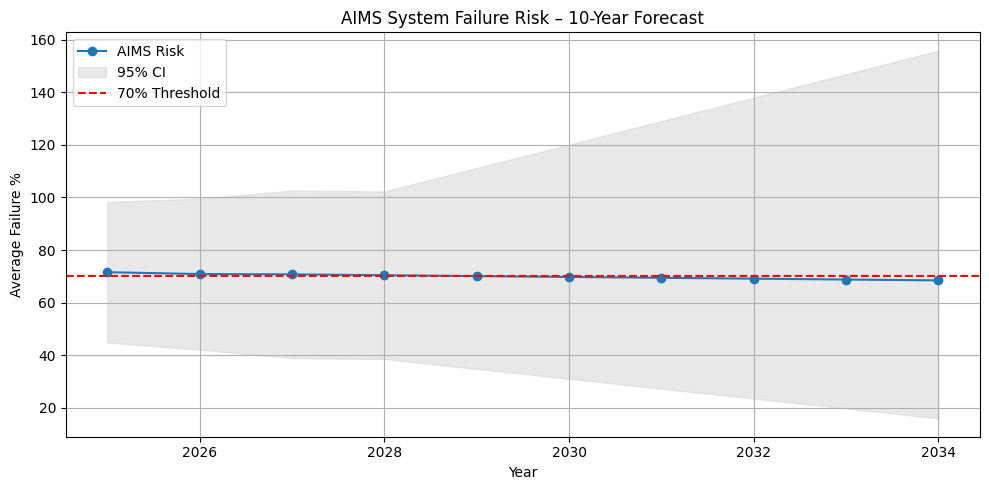

In [28]:
# 10. Export + Plot
# ------------------------------------------------------------------
overall_df.to_csv('AIMS_10year_risk.csv')
summary_df.to_csv('best_models_summary.csv', index=False)

# Plot
plt.figure(figsize=(10,5))
plt.plot(overall_df.index, overall_df['AIMS_Risk_%'], label='AIMS Risk', marker='o')
plt.fill_between(overall_df.index,
                 overall_df['Lower_95'],
                 overall_df['Upper_95'],
                 color='lightgray', alpha=0.5, label='95% CI')
plt.axhline(THRESHOLD, color='red', linestyle='--', label='70% Threshold')
plt.title('AIMS System Failure Risk – 10-Year Forecast')
plt.xlabel('Year'); plt.ylabel('Average Failure %')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()